In [33]:
import pandas as pd

data = pd.read_csv("train_data_50_main.csv")

data['Date'] = pd.to_datetime(data['Date'])

# set indexes 
data.set_index(["Ticker", "Date"], inplace=True)

print(data.head())

                       Open      High       Low     Close  Adj Close  \
Ticker Date                                                            
ZJ     2015-07-06  5.699535  5.758382  5.695429  5.747890   5.193889   
       2015-07-07  5.742872  5.754733  5.646161  5.733748   5.181111   
       2015-07-08  5.678550  5.685849  5.590051  5.591420   5.052501   
       2015-07-09  5.649811  5.659391  5.438599  5.477374   4.949447   
       2015-07-10  5.562680  5.649811  5.529379  5.623808   5.081768   

                      Volume  
Ticker Date                   
ZJ     2015-07-06  112241600  
       2015-07-07  187787200  
       2015-07-08  243046400  
       2015-07-09  314380000  
       2015-07-10  245418000  


In [34]:
# Get the tickers
tickers = data.index.get_level_values("Ticker").unique()

# Print the sorted tickers
tickers = sorted(tickers)

tick_count = 0
corrs = []
ticker1 = []
ticker2 = []
# Want to analyze the stocks that move together or not together
for i in range(tick_count, len(tickers) - 1):
    for j in range(i + 1, len(tickers)):
        percent_change_a = (data.loc[tickers[i]]["Close"] - data.loc[tickers[i]]["Open"])/data.loc[tickers[i]]["Open"]
        a_series = pd.Series(percent_change_a)
        percent_change_b = (data.loc[tickers[j]]["Close"] - data.loc[tickers[j]]["Open"])/data.loc[tickers[j]]["Open"]
        b_series = pd.Series(percent_change_b)
        # ------FOR DEBUG PRUPOSES------
        # print(f"A_SERIES: \n{a_series}")
        # print(f"B_SERIES: \n{b_series}")
        # print(f"{tickers[i]} and {tickers[j]}: {a_series.corr(b_series)}")
        corr = a_series.corr(b_series)
        corrs.append(corr)
        ticker1.append(tickers[i])
        ticker2.append(tickers[j])

correlations = pd.DataFrame({"Ticker1": ticker1, "Ticker2": ticker2, "Correlation": corrs})
print(correlations)
correlations



     Ticker1 Ticker2  Correlation
0          A       B     0.432408
1          A       C     0.370245
2          A       D     0.452107
3          A       E     0.538456
4          A       F     0.412770
...      ...     ...          ...
1220      ZU      ZW     0.311492
1221      ZU      ZX     0.333727
1222      ZV      ZW     0.632423
1223      ZV      ZX     0.426293
1224      ZW      ZX     0.505043

[1225 rows x 3 columns]


,Ticker1,Ticker2,Correlation
0,A,B,0.432408
1,A,C,0.370245
2,A,D,0.452107
3,A,E,0.538456
4,A,F,0.412770
...,...,...,...
1220,ZU,ZW,0.311492
1221,ZU,ZX,0.333727
1222,ZV,ZW,0.632423
1223,ZV,ZX,0.426293


In [35]:
#SPX highest correlation - ZO, V, P, J, 
#DJI highest correlation - ZB


In [36]:
# Sort entire correlations df by the correlation values
correlations = correlations.sort_values(by="Correlation", ascending=False)
print(correlations)

# Capture the least and most correlated tickers
top_correlated_tickers = correlations.iloc[:6]
least_correlated_tickers = correlations.iloc[len(correlations.index) - 6:len(correlations.index)]

top_correlated_tickers = top_correlated_tickers.reset_index(drop=True)

print(least_correlated_tickers)

print(top_correlated_tickers)


     Ticker1 Ticker2  Correlation
410        J       P     0.985502
84         B      ZL     0.855175
23         A       Y     0.848811
1013      ZC      ZW     0.746992
960       ZA      ZM     0.738727
...      ...     ...          ...
1140      ZK      ZR     0.078172
1047      ZE      ZR     0.076998
867        W      ZR     0.064146
1098      ZH      ZR     0.059673
1206      ZR      ZU     0.045672

[1225 rows x 3 columns]
     Ticker1 Ticker2  Correlation
372        I       R     0.081277
1140      ZK      ZR     0.078172
1047      ZE      ZR     0.076998
867        W      ZR     0.064146
1098      ZH      ZR     0.059673
1206      ZR      ZU     0.045672
  Ticker1 Ticker2  Correlation
0       J       P     0.985502
1       B      ZL     0.855175
2       A       Y     0.848811
3      ZC      ZW     0.746992
4      ZA      ZM     0.738727
5       U      ZL     0.727735


In [37]:
import numpy as np

open_prices = []
daily_volume = []

for ticker in tickers:
    stock_close_data = data.loc[ticker]["Open"]
    open_prices.append(stock_close_data.values)

open_prices = np.stack(open_prices)

trades = np.zeros_like(open_prices)

print(open_prices[0][0])

17.042949946719865


In [38]:

min_change_percent = 0.01
positions = [0] * len(tickers)
tickers_to_idx = {k: v for v, k in enumerate(tickers)}
cash_balance = 25000

buy_percentage = 0.1

for day in range(1, len(open_prices[0])-1):
    for idx in range(len(top_correlated_tickers) - 1):
        ticker1 = tickers_to_idx[top_correlated_tickers["Ticker1"][idx]]
        ticker2 = tickers_to_idx[top_correlated_tickers["Ticker2"][idx]]
        ticker1_pct_change = (open_prices[ticker1][day] - open_prices[ticker1][day-1]) / open_prices[ticker1][day-1]
        ticker2_pct_change = (open_prices[ticker2][day] - open_prices[ticker2][day-1]) / open_prices[ticker2][day-1]
        
        # After that, determine from the dataframe which stock had a higher percent change
        # lets say A and B are correlated, if A goes up more than B goes down above a certain constant (e), buy A; if A goes up smaller than B went down, short A
        if ticker1_pct_change > 0 and ticker2_pct_change < 0 and ((ticker1_pct_change - abs(ticker2_pct_change)) > min_change_percent):
            # buy ticker 1
            amt_to_buy = (buy_percentage * 25000) // open_prices[ticker1][day+1]
            if amt_to_buy * open_prices[ticker1][day+1] > cash_balance:
                amt_to_buy = cash_balance // open_prices[ticker1][day+1]
            
            trades[ticker1][day+1] = amt_to_buy
            positions[ticker1] += amt_to_buy
            cash_balance -= (amt_to_buy * open_prices[ticker1][day+1])

        elif ticker1_pct_change < 0 and ticker2_pct_change > 0 and ((ticker2_pct_change - (abs(ticker1_pct_change))) > min_change_percent):
            # buy ticker 2
            amt_to_buy = (buy_percentage * 25000) // open_prices[ticker1][day+1]
            if amt_to_buy * open_prices[ticker2][day+1] > cash_balance:
                amt_to_buy = cash_balance // open_prices[ticker2][day+1]
            
            trades[ticker2][day+1] = amt_to_buy
            positions[ticker2] += amt_to_buy
            cash_balance -= (amt_to_buy * open_prices[ticker2][day+1])

        #close out positions if both stocks moving together
        elif ticker1_pct_change > 0 and ticker2_pct_change > 0:
            if positions[ticker1] > 0:
                    trades[ticker1][day+1] = -positions[ticker1]
                    positions[ticker1] = 0
            if positions[ticker2] > 0:
                    trades[ticker2][day+1] = -positions[ticker2]
                    positions[ticker2] = 0


        # elif ticker1_pct_change > 0 and ticker2_pct_change < 0 and (ticker1_pct_change < (abs(ticker2_pct_change) - min_change_percent)):
        #     # short ticker 1
        #     trades[ticker1][day+1] = -1
        #     positions[ticker1] += -1

        # elif ticker1_pct_change < 0 and ticker2_pct_change > 0 and (ticker2_pct_change < (abs(ticker1_pct_change) - min_change_percent)):
        #     # short ticker 2
        #     trades[ticker2][day+1] = -1
        #     positions[ticker2] += -1


#close shorts
for stock in range(len(positions)):
    position = positions[stock]
    if position < 0:
            trades[stock][len(open_prices[0]) - 1] += -position



In [39]:
from eval_algo import eval_actions

portfolio_value, sharpe_ratio = eval_actions(trades, open_prices, cash=25000, verbose=True)
print(f"\nPortfolio value: {portfolio_value}")
print(f"Sharpe ratio: {sharpe_ratio}")

final portfolio value: 25191.070944123538
cash: 25191.070944123538
positions: [0.0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0]
short position info: defaultdict(<class 'list'>, {})
short value: 0

Portfolio value: [25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 25000, 24990.553346756416, 24990.553346756416, 24990.553346756416, 24990.553346756416, 24990.553346756416, 24990.553346756416, 24990.553346756416, 24990.553346756416, 24990.553346756416, 24990.553346756416, 24990.553346756416, 24990.553346756416, 24990.553346756416, 24990.553346756416, 24990.553346756416, 24990.553346756416, 24990.553346756416, 24990.553346756416, 24990.553346756416, 24990.553346756416, 24990.553346756416, 24990.553346756416, 25024.153796222075, 24988.516775405646, 24941.001092905142, 24948.807129769775, 24945.4131

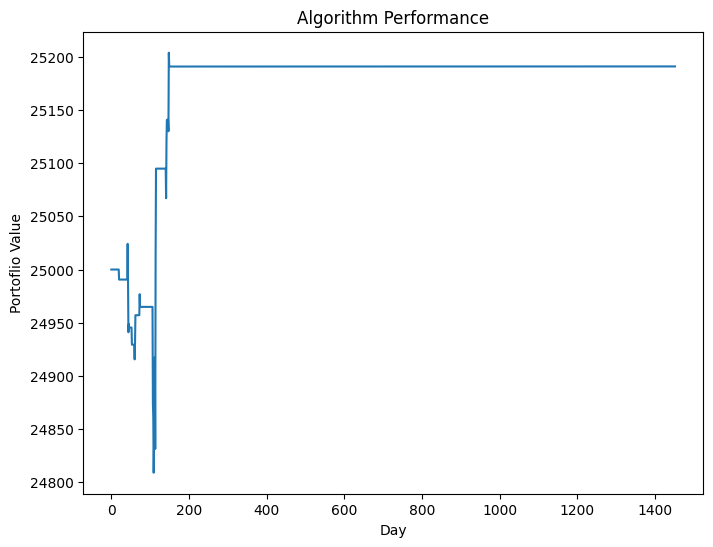

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

plt.plot(portfolio_value, label=f'{ticker}')

plt.xlabel('Day')
plt.ylabel('Portoflio Value')
plt.title('Algorithm Performance')
plt.show()